# Import Libraries

In [1]:
# import custom functions
import custom_functions as funcs

# set plots params
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight") # change plot appearances

# customisations as ref, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (12, 6) # set a figsize greater than default
mpl.rcParams["lines.linewidth"] = 2 # adjust line width
mpl.rc("font", family = "monospace", monospace = ["DejaVu Sans Mono"])
mpl.rc("axes", titlelocation = "left", titlepad = 12, titleweight = "bold")

# Retrieve Daily Datasets

First, we run a custom script to check if the `PostgreSQL` server is started or to start it.

In [2]:
!bash $MYBINS/pg_server_status

As explained in the previous chapter, inserting the data into an SQL database enables faster operations on the data - which in this case amount in most instances to `GROUP BY`. Data is hence served much faster.

Now, two datasets are retrieved: the daily outflow for the whole municipality of Milan and the daily outflow for each station in the city. The custom function `retrieve_bike_flow` has an argument, `time_column` which has a predefined value: `{"data_prelievo": "giorno_partenza"}`. This implies that the function will retrieve data aggregated on the time by which the bikes leave the station and not when they are returned once the ride is finished. In other words, by default the daily outflow will be retrieved. The parameter `trunc` is set to default to `day`: this will mean that the `time_column` will be truncated to the daily level - but this parameter can be set to other time units, such as `hour` to retrive hourly data.

In [3]:
# when no argument other than the table name is specified, daily data for Milan is retrieved
daily_outflow = funcs.retrieve_bike_flow(table = "bikemi_2019")
daily_outflow.head()

,count
giorno_partenza,
2019-01-01,831
2019-01-02,3512
2019-01-03,4126
2019-01-04,4201
2019-01-05,2875


In [4]:
# when the station_columns is specified, data for each station is retrieved
station_daily_outflow = (
    funcs.retrieve_bike_flow(
        table = "bikemi_2019",
        station_column = {"nome_stazione_prelievo" : "stazione_partenza"}
        )
    .pipe(funcs.pivot_bike_flow, cols = "stazione_partenza")
    .convert_dtypes() # make double into integers
)

station_daily_outflow.head()

,Accursio - Portello,Adamello - Lorenzini,Alserio - Cola Montano,Amendola M1,Angilberto - Comacchio,Aquileia,Arcimboldi - Innovazione,Arcivescovado,Arco della Pace 1 - Bertani,Arco della Pace 2 - Pagano,...,Verrocchio - Juvara,Vesuvio - Lipari,Vigliani - Scarampo,Villapizzone FFSS - Lambruschini,Vittor Pisani,XXII Marzo,XXIV Maggio,XXV Aprile,Zara M3,Zavattari - Tempesta
giorno_partenza,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2,1,7,2,2,1,3,10,4,6,...,2,<NA>,<NA>,1,6,1,3,14,<NA>,2
2019-01-02,10,7,13,8,2,4,7,29,22,14,...,12,4,2,2,19,7,11,39,3,2
2019-01-03,13,5,9,13,2,8,6,26,15,21,...,15,14,4,3,32,6,14,30,7,5
2019-01-04,10,8,15,13,2,6,1,19,21,23,...,9,13,1,1,29,11,15,45,8,3
2019-01-05,14,4,5,8,1,14,2,22,19,20,...,10,11,1,3,14,8,12,29,6,2


## Filter out invalid data

Before proceeding with the time series analysis, we first need to check out if the retrieved data belongs to the 2019. (Quick note: since the index is a datetime index, we can subset the data very easily by using, for example, this notation: `daily_outflow.loc["2019-10"]`.)

The quickest way of doing it is by checking the length of our datasets:

In [5]:
print(f"Lenght of `daily_outflow` is {len(daily_outflow)}\nLength of `station_daily_outflow` is {len(station_daily_outflow)}")

Lenght of `daily_outflow` is 366
Length of `station_daily_outflow` si 366


We can further inspect the issue by looking at the last values of either dataset:

In [5]:
daily_outflow.tail()

,count
giorno_partenza,
2019-12-28,1944
2019-12-29,1269
2019-12-30,2698
2019-12-31,2126
2020-01-01,31


How come 31 trips from the year 2020 sneaked in? The data comes from serveral `.xlsx` files that were put into a local database, to make retrieval faster. In other words, these observations were already there. If the analysis is performed by concatenating all tables for all years, the problem will be fixed. In the meantime, dropping these observations will do.

In [6]:
daily_outflow = daily_outflow.loc[daily_outflow.index != "2020-01"]
station_daily_outflow = station_daily_outflow.loc[station_daily_outflow.index != "2020-01"]

# Time Series Analysis

## Univariate Time Series

Let's plot the data:

<AxesSubplot:title={'left':'Daily Count of Trips in Milan'}, xlabel='Time'>

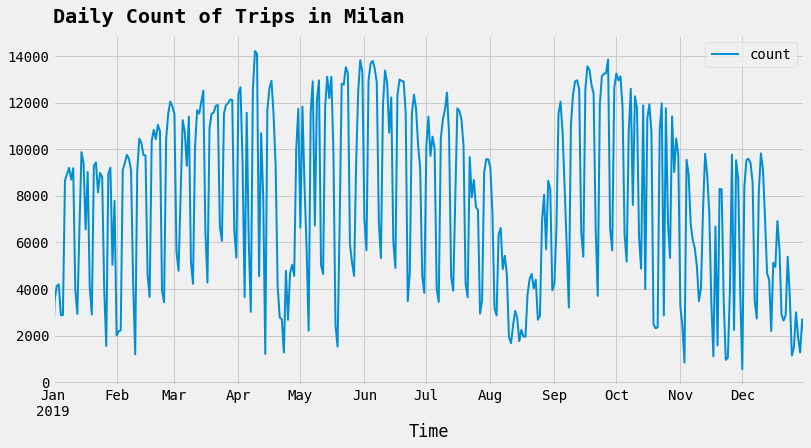

In [12]:
daily_outflow.plot(
    y="count",
    title="Daily Count of Trips in Milan",
    xlabel="Time",
    ylabel=None
)

The first thing that comes to mind is that the series displays a great variance. Then, there are three troughs, in correspondence of the major holidays: April with Easter, the weeks before and after August 15, and the end of the year. Clearly, the data is non-stationary. We can clearly see a trend, where the trip number increases until the middle of the year and then starts decreasing, reaching its lowest in the colder winter months. We can plot rolling means to get a better sense of these fluctuations.

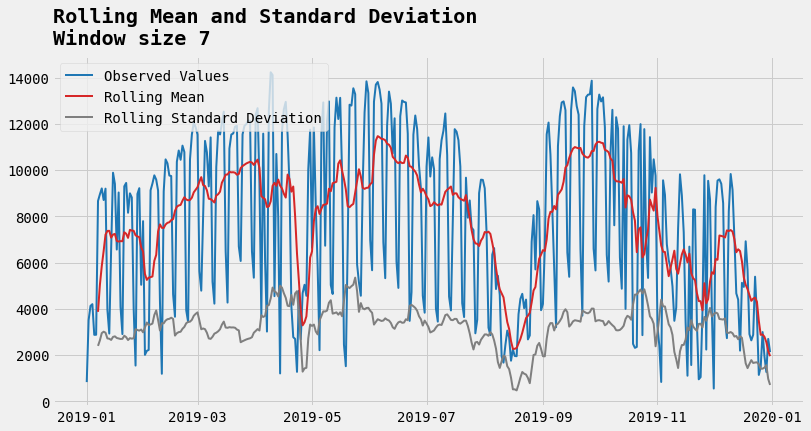

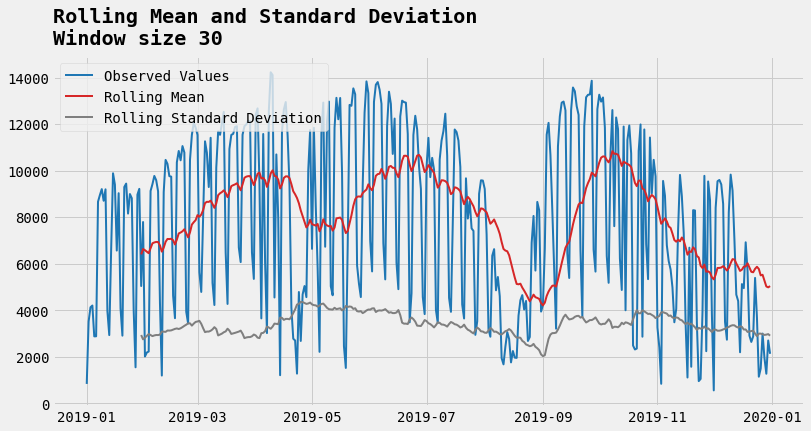

In [9]:
for lag in [7, 30]:
    funcs.rolling_statistics(daily_outflow, lags=lag, statistics = ["mean", "std"])

We could plot the individual values for each month to display the difference in values. However, we can show these features better with a boxplot:

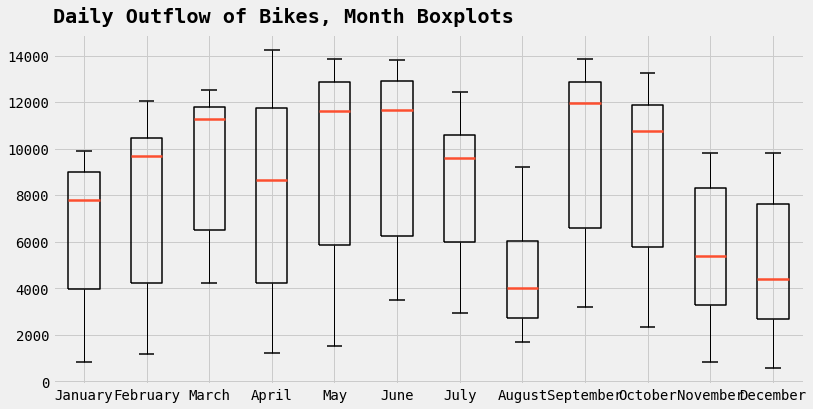

In [9]:
funcs.subunits_boxplot(daily_outflow, y = "count", time_subunit = "month")

However, the most important source of variation clearly is the weekly seasonality. The boxplot function is designed to accept various time formats, so we can adapt it pretty quickly:

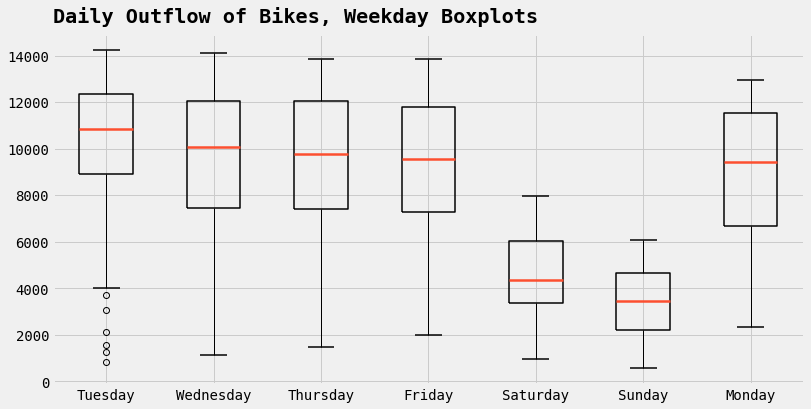

In [23]:
funcs.subunits_boxplot(daily_outflow, y = "count", time_subunit = "weekday")

Given this distribution, we expect a strong relationship between data points that are seven lags from each other. More importantly, we expect that this variance will hinder the accuracy of our forecasts. This may require transforming the data (e.g. by taking logs or applying a Box-Cox transformation and searching for the optimal parameter $\lambda$) or *decomposing the time series*.

# Autocorrelation

Let's have a look at the autocorrelation function, before proceeding.

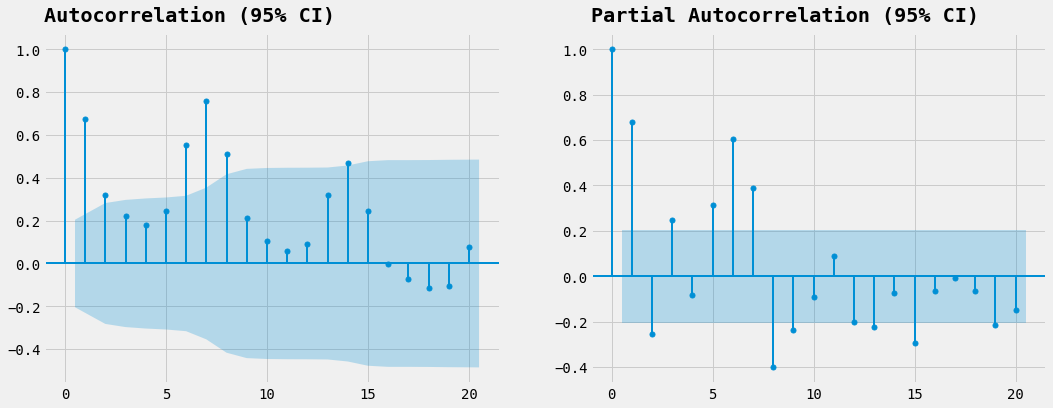

In [11]:
funcs.plot_acf_and_pacf(daily_outflow["count"])

Both plots show that the data is (unsurprisingly) non stationary. Besides, the ACF plot shows two components of the time-series:

* a trend, as the autocorrelation is declining;
* a (strong) seasonal component on the seventh lag - i.e., a stron weekly dependence.

The correlation quickly becomes statistically indistinguisheable from zero.

Let's perform a Dickey Fuller test.

# Advanced Dickey Fuller Test

In [12]:
funcs.perform_adfuller(daily_outflow["count"])


        Test Statistics: -1.3164000164404412
        p-value: 0.8838130376998452

        Number of lags: 8
        Number of observations: 83

        Critical Value (1%): -4.072204696661519
        Critical Value (5%): -3.464777396530526
        Critical Value (10%): -3.158810696553087

        AIC: 1397.1737393790502

        The series is non-stationary 
        


The test statistic is greater than any critical value: in other words, we cannot reject the null hypothesis and the series is indeed non-stationary.

# Time-Series Decomposition

There are several alternatives:

* Apply a transformation (e.g., take logs);
* Subtract the rolling average (it can work here, since the frequency is clear. It becomes more complex in case of high-frequency data: which window shall be selected?)

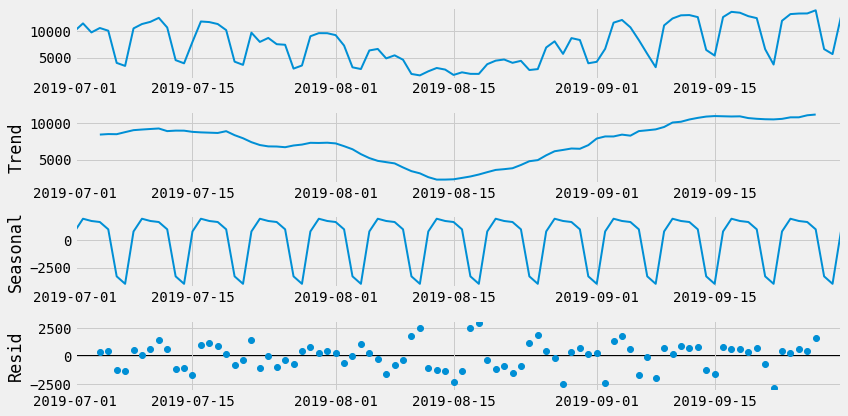

In [13]:
tsa.seasonal_decompose(daily_outflow, model = "additive").plot();